In [1]:
import torch
from usta_model import UstaModel
from usta_tokenizer import UstaTokenizer

u_tokenizer = UstaTokenizer("tokenizer.json")

prompt = "the capital of united"

tokens = u_tokenizer.encode(prompt)
tokens

tensor([ 0, 61,  1, 61,  2, 61,  3])

In [2]:
torch.manual_seed(1)
u_model = UstaModel(vocab_size=len(u_tokenizer.vocab), embedding_dim=4, num_heads=2, context_length=32)

sentence_meanings_with_atention_context = u_model(tokens)
sentence_meanings_with_atention_context.shape

torch.Size([7, 4])

In [3]:
out = u_model(tokens)
out

tensor([[ 0.2463, -0.4891, -1.2332,  1.4761],
        [ 0.0318, -0.6780, -0.9673,  1.6134],
        [-0.4828,  0.1527, -1.1929,  1.5230],
        [-0.1944, -0.8273, -0.6629,  1.6845],
        [-0.0228, -0.9641, -0.6428,  1.6297],
        [-0.2027, -0.7301, -0.7563,  1.6891],
        [-0.0490, -0.9146, -0.6792,  1.6428]], grad_fn=<MulBackward0>)

In [4]:
from usta_layer_norm import UstaLayerNorm

norm_layer = UstaLayerNorm(4)
norm_layer(out)

tensor([[ 0.2463, -0.4892, -1.2333,  1.4762],
        [ 0.0318, -0.6780, -0.9674,  1.6135],
        [-0.4829,  0.1527, -1.1931,  1.5232],
        [-0.1944, -0.8273, -0.6629,  1.6847],
        [-0.0228, -0.9642, -0.6429,  1.6299],
        [-0.2027, -0.7301, -0.7564,  1.6893],
        [-0.0490, -0.9147, -0.6793,  1.6430]], grad_fn=<MulBackward0>)

In [5]:
u_model

UstaModel(
  (embedding): Embedding(64, 4)
  (pos_embedding): Embedding(64, 4)
  (self_attation): UstaMultiHeadAttention(
    (multi_head_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (projection): Linear(in_features=4, out_features=4, bias=True)
  )
  (norm): UstaLayerNorm()
)

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

q_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B")
q_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-0.6B")

c:\Users\Artun\anaconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


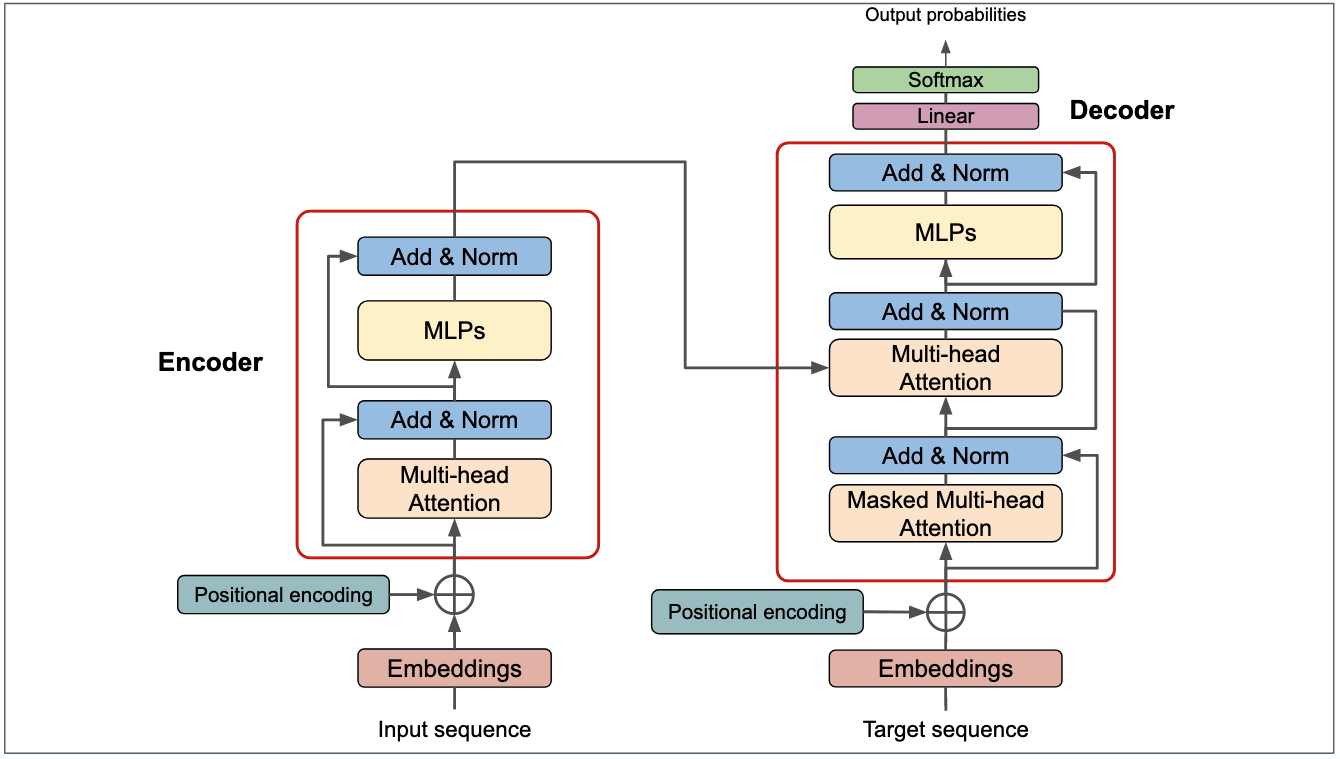

In [7]:
q_model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layer

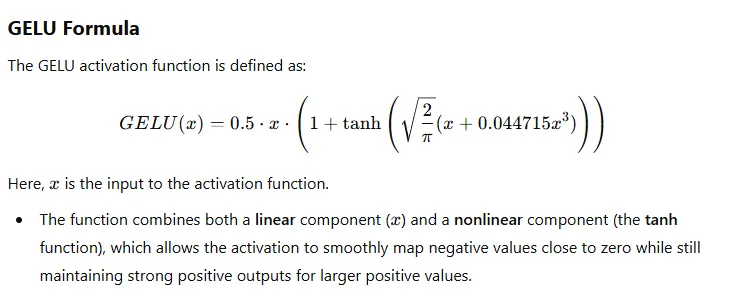

In [8]:
import torch.nn as nn

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (
      1 + torch.tanh(
          torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        )
    )


gelu = GELU()

example_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
gelu(example_tensor)

tensor([[0.8412, 1.9546, 2.9964],
        [3.9999, 5.0000, 6.0000]])

In [9]:
# import torch funtions 

import torch.nn.functional as F

F.gelu(example_tensor, approximate="tanh")

tensor([[0.8412, 1.9546, 2.9964],
        [3.9999, 5.0000, 6.0000]])

In [10]:
import torch.functional as F

class UstaMLP(nn.Module):
  def __init__(self, embedding_dim, hidden_dim):
    super().__init__()

    self.gate_proj = nn.Linear(embedding_dim, hidden_dim)
    self.up_proj = nn.Linear(embedding_dim, hidden_dim)
    self.down_proj = nn.Linear(hidden_dim, embedding_dim)
    self.gelu = GELU()

  def forward(self, x):
    """ gate = self.gate_proj(x)
        gate = F.gelu(gate, approximate="tanh")
        up = self.up_proj(x)
        fuse = gate * up
        outputs = self.down_proj(fuse) """
    gate = self.gate_proj(x)
    gate = self.gelu(gate)
    up = self.up_proj(x)
    fuse = gate * up
    outputs = self.down_proj(fuse)
    return outputs

In [14]:
import torch.nn as nn
from usta_multi_head_attention import UstaMultiHeadAttention
from usta_layer_norm import UstaLayerNorm
from usta_mlp import UstaMLP

class UstaDecoderBlock(nn.Module):
  def __init__(self, embedding_dim, num_heads, context_length):
    super().__init__()

    self.self_attention = UstaMultiHeadAttention(embedding_dim, embedding_dim, context_length, num_heads, dropout_rate=0.5)
    self.norm1 = UstaLayerNorm(embedding_dim)
    self.mlp = UstaMLP(embedding_dim, embedding_dim)
    self.norm2 = UstaLayerNorm(embedding_dim)

  def forward(self, x):
    res = self.norm1(x)

    x = self.self_attention(x)
    x = self.norm1(x)

    x = x + res

    res = self.norm2(x)
    x = self.mlp(x)
    x = self.norm2(x)

    x = x + res

    return x

example_tensor = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=torch.float32)
decoder_block = UstaDecoderBlock(embedding_dim=4, num_heads=2, context_length=3)
decoder_block(example_tensor)

tensor([[ 1.6116, -0.8949, -2.4376,  1.7209],
        [-1.1496,  1.6351, -1.9441,  1.4586]], grad_fn=<AddBackward0>)